In [22]:
#import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [23]:
#load datasets. I have 5 files each one is a season of data. 18-19, 19-20, 20-21, 21-22, and 22-23 


file_names = ['WyScoutData.xlsx', 'WyScoutData2.xlsx', 'WyScoutData3.xlsx', 'WyScoutData4.xlsx', 'WyScoutData5.xlsx']
dataframes = [pd.read_excel(file) for file in file_names]


In [24]:
# Assign test_data and train_data
test_data_raw = dataframes[0]  # WyScoutData.xlsx
train_data_raw = pd.concat(dataframes[1:], ignore_index=True)  # WyScoutData2.xlsx, WyScoutData3.xlsx, WyScoutData4.xlsx, WyScoutData5.xlsx
pd.set_option('display.max_columns', None)


In [25]:
# Function to preprocess the data
def preprocess_data(raw_data):
    player_stats = raw_data.copy()

    # Only include players with 900 or more minutes played. (10 games), fill NaN with 0 on prevented goals
    player_stats = player_stats[player_stats['Minutes played'] >= 900]
    player_stats['Prevented goals'] = player_stats['Prevented goals'].fillna(0)

    # Clean up position data. Make it one position instead of multiple.
    position_columns = player_stats['Position'].str.split(',', expand=True)
    position_columns.columns = [f'Position {i+1}' for i in range(position_columns.shape[1])]
    player_stats = pd.concat([player_stats, position_columns], axis=1)
    player_stats = player_stats.drop(['Position 2', 'Position 3'], axis=1)
    
    #Move position 1 to near the front of the data frame.
    columns = player_stats.columns.tolist()
    columns.remove('Position 1')
    position_index = columns.index('Position')
    columns.insert(position_index + 1, 'Position 1')
    player_stats = player_stats[columns]
    
    #Reduce no of positions to make it easier to work with.
    position_replacements = {
        'LWF': 'LW',
        'RWF': 'RW',
        'RCMF': 'CM',
        'LCMF': 'CM',
        'LDMF': 'DMF',
        'RDMF': 'DMF',
        'LCB': 'CB',
        'RCB': 'CB',
        'RAMF' : 'AMF',
        'LAMF' : 'AMF'
    }
    
    #Drop unnecessary columns
    player_stats['Position 1'] = player_stats['Position 1'].replace(position_replacements)
    player_stats = player_stats.drop(['Position', 'Age', 'Market value', 'Contract expires', 'Minutes played', 'Birth country', 'Height', 'Weight'], axis = 1)

    return player_stats

In [26]:
# Preprocess the training and test data
train_data = preprocess_data(train_data_raw)
test_data = preprocess_data(test_data_raw)

In [27]:
# See what processed data looks like in csv format.

#export as csv
train_data.to_csv('train_data_concatenated.csv', index=False)
test_data.to_csv('test_data_concatenated.csv', index=False)

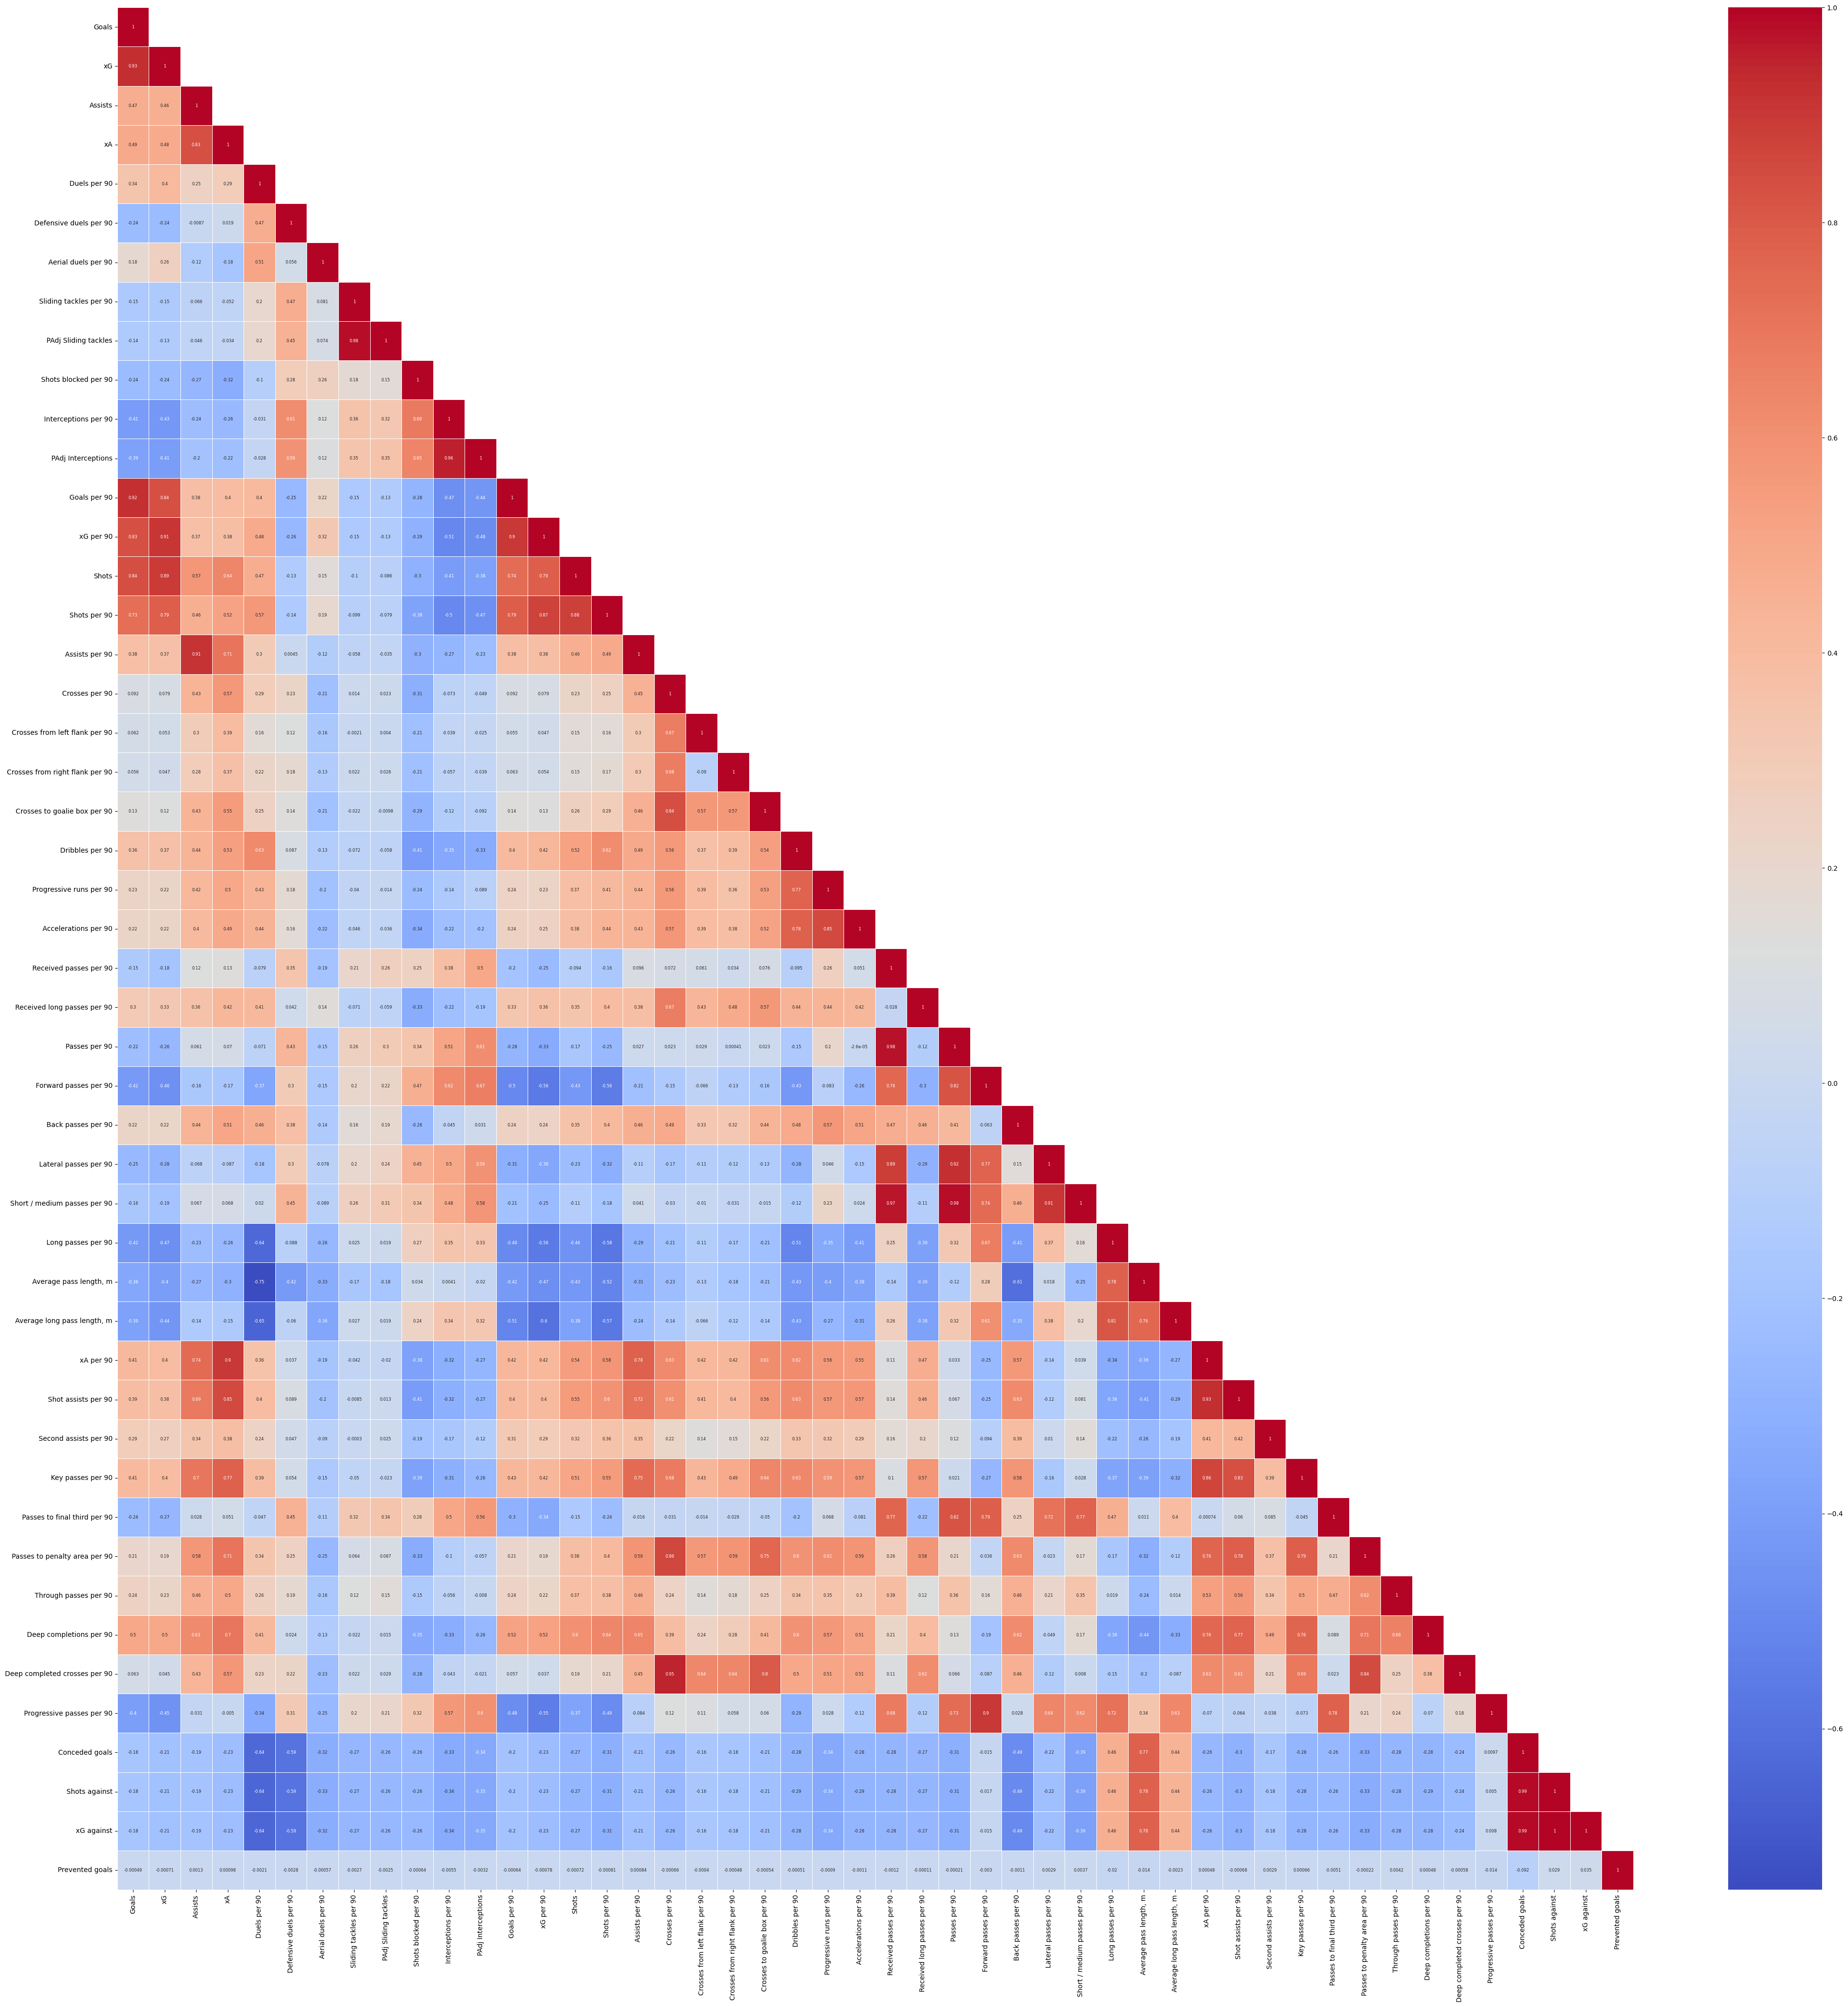

In [28]:
# Drop the non-numerical columns and then define correlation matrix
correlation_matrix = train_data.drop(['Player', 'Team', 'Position 1'], axis=1).corr()

# Set the figure size
plt.figure(figsize=(50, 50))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Create the heatmap with an adjusted font size and the mask
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask, annot_kws={"size": 6})

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

In [29]:
# Prepare the features (X) and target labels (y):
X_train = train_data.drop(['Position 1', 'Team', 'Player'], axis=1)
y_train = train_data['Position 1']

X_test = test_data.drop(['Position 1', 'Team', 'Player'], axis=1)
y_test = test_data['Position 1']

In [30]:
#encode target labels and split into training and testing datasets
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)  # Use transform() instead of fit_transform() to use the same encoding as the training data

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [31]:
#design the neural network.
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification (classes are positions)

In [32]:
#compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [33]:
#train the model
history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
220/220 [==============================] - 1s 2ms/step - loss: 1.3878 - accuracy: 0.5733 - val_loss: 0.9736 - val_accuracy: 0.6642
Epoch 2/50
220/220 [==============================] - 0s 1ms/step - loss: 0.8219 - accuracy: 0.7115 - val_loss: 0.8792 - val_accuracy: 0.7029
Epoch 3/50
220/220 [==============================] - 0s 1ms/step - loss: 0.7255 - accuracy: 0.7338 - val_loss: 0.6794 - val_accuracy: 0.7536
Epoch 4/50
220/220 [==============================] - 0s 1ms/step - loss: 0.6545 - accuracy: 0.7452 - val_loss: 0.6217 - val_accuracy: 0.7558
Epoch 5/50
220/220 [==============================] - 0s 1ms/step - loss: 0.6165 - accuracy: 0.7576 - val_loss: 0.6109 - val_accuracy: 0.7581
Epoch 6/50
220/220 [==============================] - 0s 1ms/step - loss: 0.6088 - accuracy: 0.7617 - val_loss: 0.5942 - val_accuracy: 0.7718
Epoch 7/50
220/220 [==============================] - 0s 1ms/step - loss: 0.5827 - accuracy: 0.7663 - val_loss: 0.5673 - val_accuracy: 0.7780
Epoch 

In [34]:
#evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy*100:.2f}%")

68/68 [==============================] - 0s 1ms/step - loss: 0.6534 - accuracy: 0.7455
Test loss: 0.6534, Test accuracy: 74.55%


In [35]:
#save the model
model.save('player_position_classifier.h5')

import pickle
with open('label_encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)

C:\Users\AmarL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
# now convert actual position labels from encoded format to original format and create new dataframe comparison_df to see
#comparison

y_pred = model.predict(X_test)

# New code to print the vectors
print("Vectors:")
for vector in y_pred[:5]:
    print(vector)

y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_decoded = encoder.inverse_transform(y_pred_labels)
y_test_decoded = encoder.inverse_transform(y_test_encoded)
comparison_df = pd.DataFrame({'Actual Position': y_test_decoded, 'Predicted Position': y_pred_decoded})

68/68 [==============================] - 0s 967us/step
Vectors:
[4.3152110e-04 9.4195093e-05 3.5487985e-06 1.3049768e-03 5.0288259e-06
 7.8806270e-13 6.1608040e-01 9.0100913e-04 3.7957332e-01 1.1109336e-03
 7.7236800e-05 4.1781823e-04]
[2.2129478e-05 1.3416820e-02 2.8898026e-07 2.7708053e-03 2.5637127e-03
 8.6408619e-07 8.3321512e-02 2.8374370e-06 8.7141874e-04 8.7393093e-01
 1.0052937e-04 2.2998178e-02]
[7.4002697e-09 9.9945360e-01 5.4316506e-14 3.3811735e-05 3.3669334e-04
 1.4461607e-12 8.0171136e-05 1.5164309e-12 3.6061653e-08 9.5696691e-05
 3.5636472e-09 6.9835174e-08]
[6.2667198e-02 1.0072512e-05 1.1055077e-02 3.7842289e-01 2.7532398e-03
 4.9353758e-07 3.5948981e-06 9.1472529e-02 1.0893845e-06 1.7759112e-04
 4.5016167e-01 3.2744226e-03]
[1.3294969e-03 7.5644515e-05 6.5625900e-05 1.9886333e-03 5.8540163e-06
 7.6466868e-11 2.3464482e-01 8.7378116e-04 6.6596520e-01 3.5983577e-02
 1.5827445e-03 5.7484642e-02]


In [37]:
#Add back all original data that was initially dropped
test_data['Actual Position'] = y_test_decoded
test_data['Predicted Position'] = y_pred_decoded
test_data.head(10)

,Player,Team,Position 1,Goals,xG,Assists,xA,Duels per 90,Defensive duels per 90,Aerial duels per 90,Sliding tackles per 90,PAdj Sliding tackles,Shots blocked per 90,Interceptions per 90,PAdj Interceptions,Goals per 90,xG per 90,Shots,Shots per 90,Assists per 90,Crosses per 90,Crosses from left flank per 90,Crosses from right flank per 90,Crosses to goalie box per 90,Dribbles per 90,Progressive runs per 90,Accelerations per 90,Received passes per 90,Received long passes per 90,Passes per 90,Forward passes per 90,Back passes per 90,Lateral passes per 90,Short / medium passes per 90,Long passes per 90,"Average pass length, m","Average long pass length, m",xA per 90,Shot assists per 90,Second assists per 90,Key passes per 90,Passes to final third per 90,Passes to penalty area per 90,Through passes per 90,Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,Conceded goals,Shots against,xG against,Prevented goals,Actual Position,Predicted Position
0,Hugo Bueno,Wolverhampton Wanderers,LB,0,0.14,1,1.78,18.27,8.03,2.07,0.07,0.09,0.13,4.68,6.10,0.00,0.01,4,0.27,0.07,2.81,2.81,0.00,0.40,3.28,2.54,1.34,22.01,1.94,33.93,10.84,8.97,7.70,29.24,1.87,16.36,21.00,0.12,1.00,0.00,0.40,2.14,2.54,0.33,0.33,0.94,4.68,0,0,0.00,0.00,LB,LB
1,Jonny Otto,Wolverhampton Wanderers,RB,1,0.27,0,0.41,19.75,7.72,2.62,0.52,0.73,0.26,5.17,7.18,0.07,0.02,8,0.52,0.00,1.50,0.46,1.05,0.07,2.42,1.64,0.39,33.16,1.24,44.93,16.35,7.26,13.67,40.49,3.07,16.98,32.08,0.03,0.26,0.00,0.07,6.21,1.70,0.39,0.33,0.33,6.87,0,0,0.00,0.00,RB,RB
2,C. Dawson,Wolverhampton Wanderers,CB,1,2.09,0,0.10,11.80,4.09,4.55,0.29,0.40,1.05,5.48,7.34,0.04,0.09,16,0.67,0.00,0.08,0.00,0.08,0.00,0.17,0.29,0.00,30.38,0.04,43.36,17.82,3.20,18.79,37.08,6.24,23.07,41.95,0.00,0.08,0.00,0.04,5.60,0.34,0.38,0.13,0.00,7.92,0,0,0.00,0.00,CB,CB
4,Matheus Nunes,Wolverhampton Wanderers,AMF,1,2.85,1,1.46,21.55,6.54,2.42,0.33,0.43,0.18,3.15,4.18,0.04,0.10,26,0.94,0.04,1.45,0.43,1.01,0.18,3.15,1.77,0.98,23.54,0.94,33.34,7.12,7.85,12.80,28.93,3.04,18.98,34.50,0.05,0.58,0.00,0.29,3.36,1.95,0.54,0.40,0.40,3.76,0,0,0.00,0.00,AMF,RW
5,R. Aït Nouri,Wolverhampton Wanderers,LB,1,1.24,0,0.76,21.67,9.46,2.99,0.47,0.67,0.00,3.63,5.11,0.08,0.10,9,0.71,0.00,1.73,1.73,0.00,0.16,4.65,2.05,0.95,28.13,3.70,36.02,12.85,7.17,9.14,32.31,2.05,16.54,18.08,0.06,0.32,0.00,0.24,3.70,2.44,0.55,0.71,0.55,6.46,0,0,0.00,0.00,LB,LWB
6,João Moutinho,Wolverhampton Wanderers,AMF,0,1.27,2,2.02,14.63,7.92,1.90,0.65,0.86,0.23,3.80,5.06,0.00,0.06,15,0.69,0.09,1.30,0.42,0.79,0.09,0.51,0.79,0.19,30.00,0.74,43.06,12.69,7.22,17.36,37.96,3.84,17.51,29.86,0.09,1.11,0.00,0.28,6.71,2.36,1.16,0.88,0.46,6.85,0,0,0.00,0.00,AMF,CM
7,Diego Costa,Wolverhampton Wanderers,CF,1,3.67,0,0.64,22.50,3.36,7.45,0.66,0.90,0.15,1.53,2.10,0.07,0.27,23,1.68,0.00,0.44,0.15,0.29,0.00,1.61,0.58,0.29,8.99,1.53,13.22,2.19,3.80,3.51,12.64,0.15,12.81,3.65,0.05,0.73,0.00,0.29,0.73,0.88,0.29,0.66,0.00,0.88,0,0,0.00,0.00,CF,CF
8,M. Lemina,Wolverhampton Wanderers,CM,0,0.31,0,0.00,14.70,6.50,1.48,0.59,0.82,0.44,4.21,5.88,0.00,0.02,9,0.67,0.00,0.15,0.00,0.15,0.00,1.18,0.59,0.37,25.86,0.22,37.76,9.98,6.35,16.33,35.10,2.51,18.19,28.72,0.00,0.00,0.00,0.00,3.99,0.67,0.52,0.22,0.15,4.88,0,0,0.00,0.00,CM,CM
9,Nélson Semedo,Wolverhampton Wanderers,RB,0,0.19,1,1.17,19.82,9.23,2.60,0.10,0.14,0.42,5.07,6.78,0.00,0.01,5,0.17,0.03,1.84,0.03,1.80,0.31,1.87,1.39,0.90,28.84,2.29,38.87,14.16,8.82,9.37,33.67,3.47,17.09,30.22,0.04,0.31,0.03,0.21,4.06,1.70,0.38,0.45,0.49,7.08,0,0,0.00,0.00,RB,RB
10,José Sá,Wolverhampton Wanderers,GK,0,0.00,0,0.00,0.94,0.10,0.47,0.00,0.00,0.00,1.28,1.73,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.03,14.34,0.16,19.76,9.81,0.03,9.03,13.69,6.07,29.31,46.91,0.00,0.00,0.00,0.00,1.17,0.05,0.13,0.00,0.00,4.66,50,153,50.79,0.79,GK,GK


In [38]:
#export as csv
test_data.to_csv('test_data_with_predictions.csv', index=False)


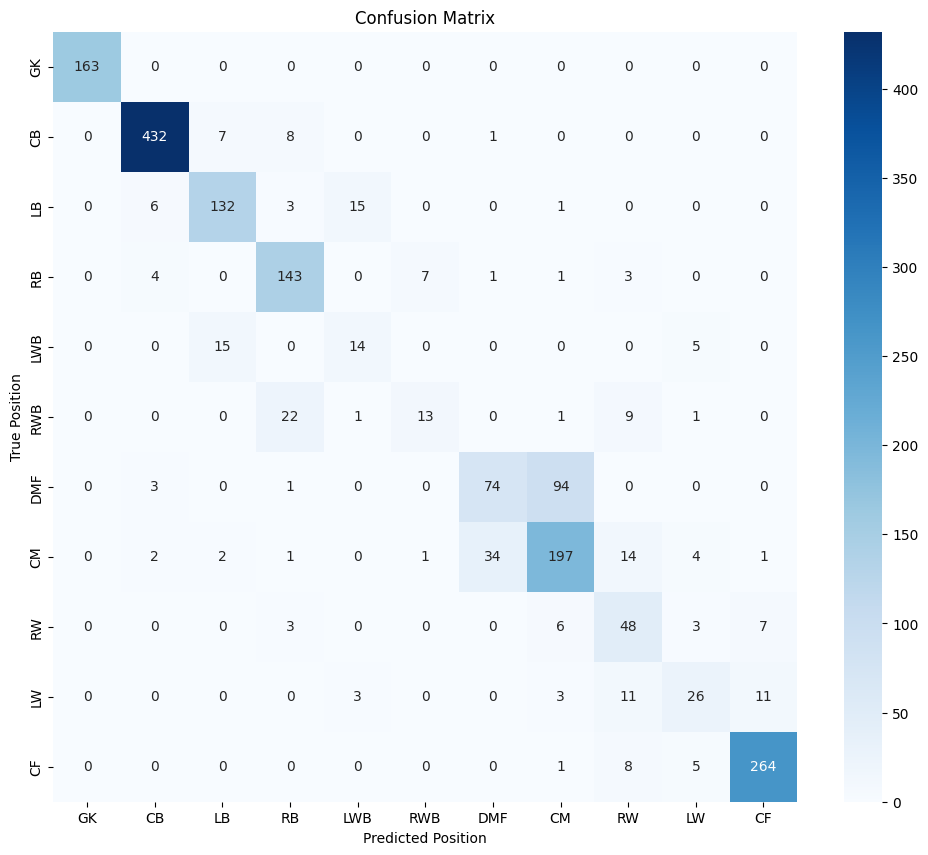

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the desired order for positions
position_order = ['GK', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'DMF', 'CM', 'RW', 'LW', 'CF']

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_decoded, labels=position_order)

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=position_order, yticklabels=position_order)
plt.xlabel('Predicted Position')
plt.ylabel('True Position')
plt.title('Confusion Matrix')
plt.show()